# Predicting blood transfusions
When a person loses high blood from an accident, operation, or has health problems, they may need to receive a blood transfusion. However, since human blood is a substance that cannot currently be manufactured, it is necessary to obtain it from another person, i.e. a blood donor.

It would be good to have way of predicting which people are most likely to donate blood to them, so then those people could be contacted.

In [12]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [13]:
import warnings
warnings.filterwarnings("ignore")

## Importing data
We are using the Blood Transfusion Service Center Data Set, available at the UCI Machine Learning Repository. This dataset consists of the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes their blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months in March 2007, with 748 donor rows, each one included :
1.	**R**ecency — time since last donation (months);
2.	**F**requency — total number of donations;
3.	**M**onetary — total blood donated (cubic centimeters),
4.	**T**ime — time since first donation (months); and
5.	**T**arget — represented here by the binary column stating whether a donor in the database has donated blood in March 2007 (1 = yes, 0 = no).

In [14]:
import pandas as pd

transfusion = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data', sep=',')
#rename columns
transfusion = transfusion.rename(columns={'Recency (months)':'Recency',
                                   'Frequency (times)':'Frequency','Monetary (c.c. blood)':'Volume',
                                    'Time (months)':'Time', 'whether he/she donated blood in March 2007':'Target'})
transfusion.head()

,Recency,Frequency,Volume,Time,Target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [15]:
len(transfusion)

748

In a first step you can check for null data

In [16]:
transfusion.isnull().sum()

Recency      0
Frequency    0
Volume       0
Time         0
Target       0
dtype: int64

No null data is observed in this dataset for any characteristic. Now you can check the correlation that exists between the different characteristics.

Information can be presented in a more visual way using heat maps.

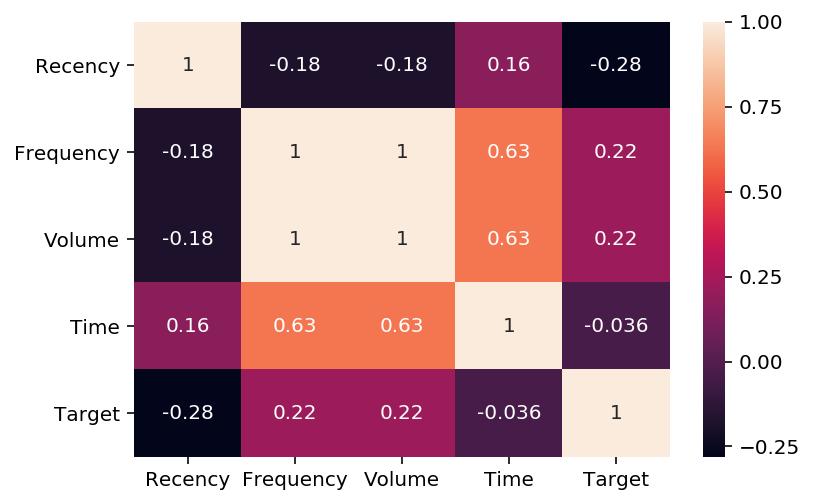

In [17]:
from seaborn import heatmap

heatmap(transfusion.corr(), annot = True);

A strong correlation is observed between the Frequency and volume of donated blood. A high frequency between Time and Frequency and Volume can also be observed.

Another way to visualize the data and render all against all to check the correlations.

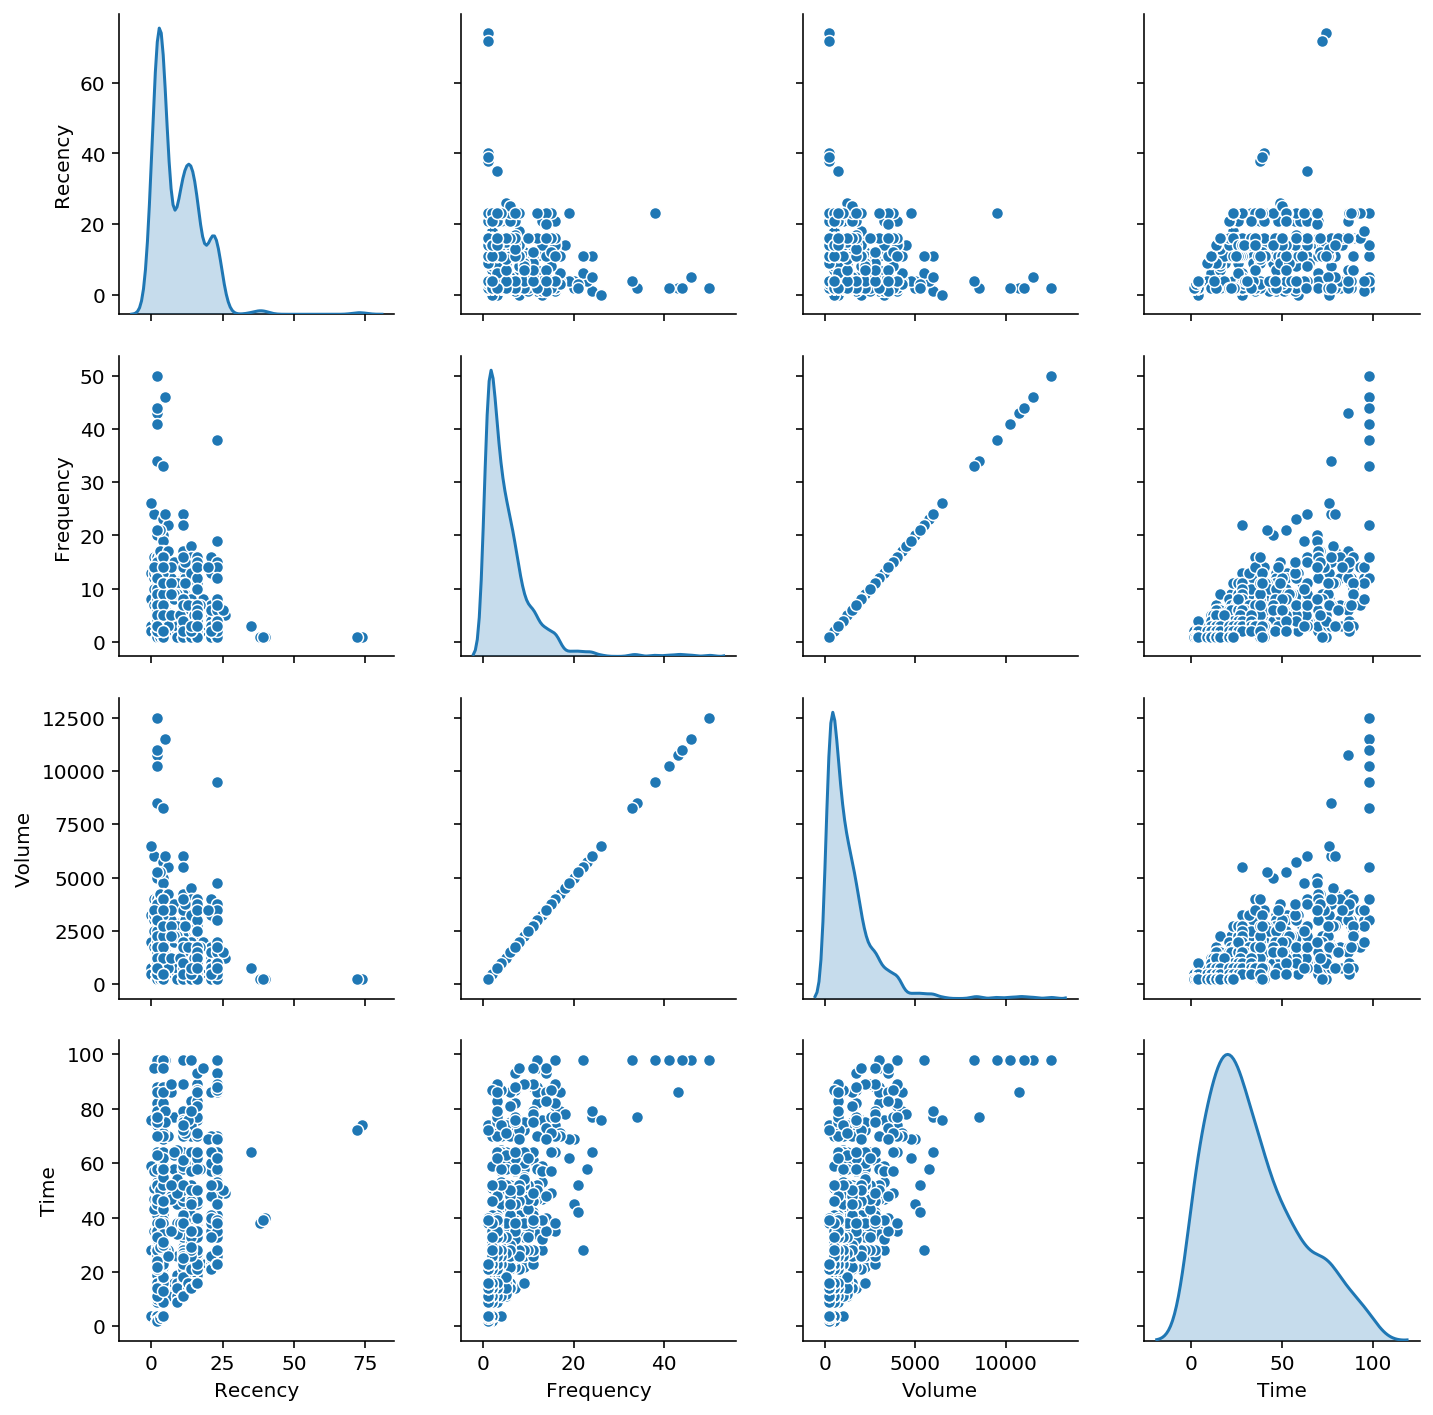

In [18]:
from seaborn import pairplot

pairplot(transfusion.iloc[:, 0:4], diag_kind = 'kde');

## Histograms
To analyze the effect of each of the different characteristics on whether or not blood donors donate in that year, histograms can be used. To do this, we will create a function that represents the distribution of current donors based on the characteristics. In red it represents those who did not donate and in blue those who donated.

In [19]:
from seaborn import distplot

def plot_distribution(data, feature, target):
    min_value = floor(min(data[feature]) - 1)
    max_value = ceil(max(data[feature]) + 1)

    bins = range(int(min_value), int(max_value), int(max(1, round((max_value - min_value) / 20))))

    distplot(transfusion[data[target] == 0][feature],
             bins = bins,
             color = 'red')
    distplot(transfusion[data[target] == 1][feature], 
             bins = bins,
             color = 'blue')

First, it can be applied to **R**ecency, the time elapsed since the last time I give blood.

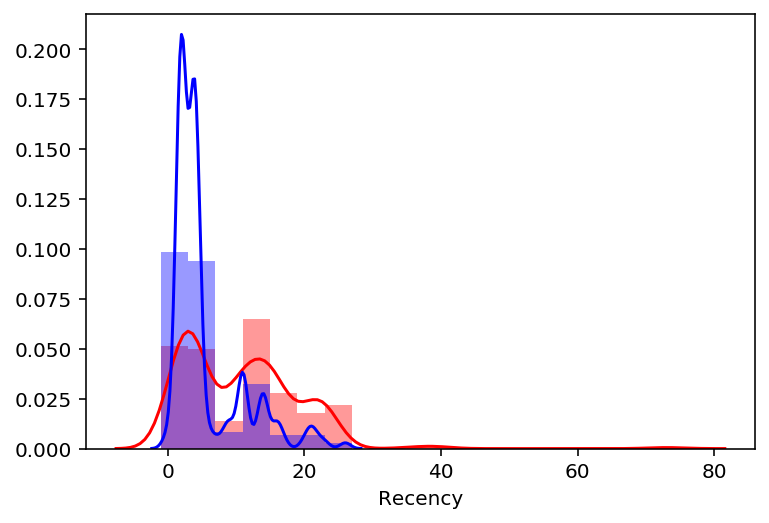

In [20]:
plot_distribution(transfusion, 'Recency', 'Target')

Note as you would expect, that the longer you have donated (Recency) there is a better chance that the donor does NOT where you bleed this year.

The **F**requency can now be analyzed.

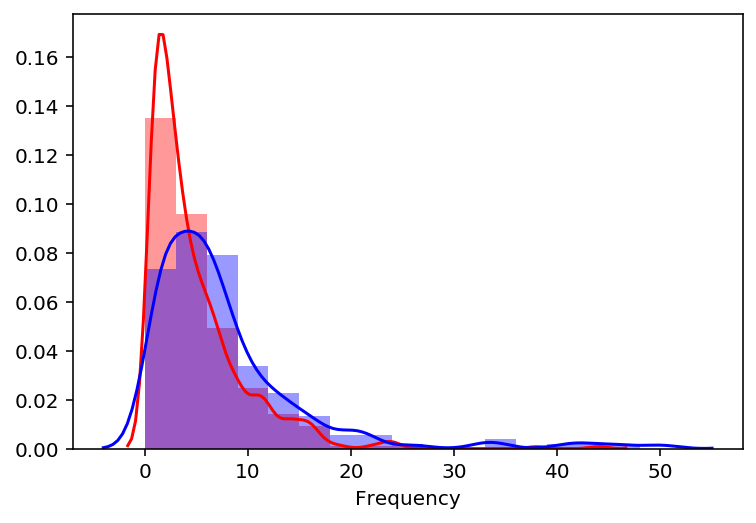

In [22]:
plot_distribution(transfusion, 'Frequency', 'Target')

In the **F**requency the only thing that can be note is the fact that those who donate less frequently are less likely to donate this year.

It can also be studied how blood volume relates to probability.

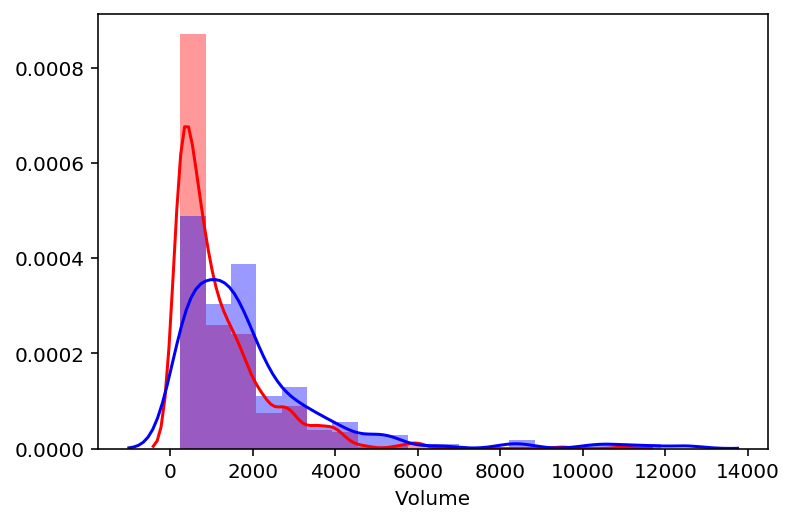

In [23]:
plot_distribution(transfusion, 'Volume', 'Target')

In this case you get a result very similar to the **F**requency. Lower **V**olume indicates lower probability.

Finally, you can study how long you've been a donor.

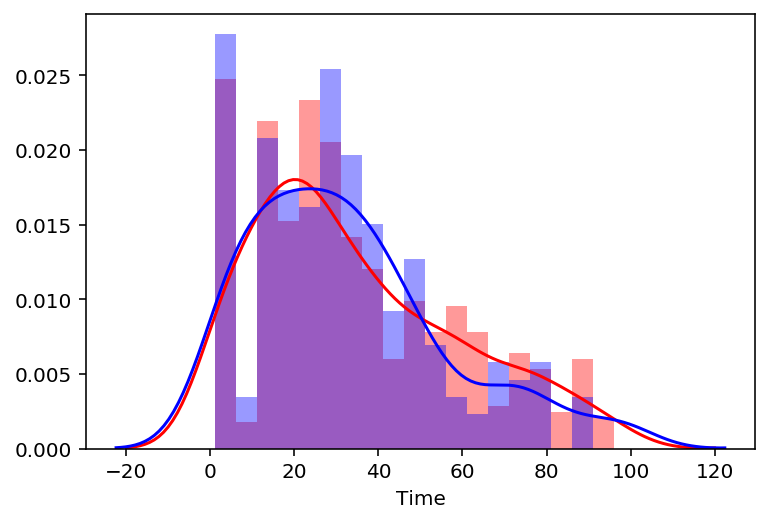

In [24]:
plot_distribution(transfusion, 'Time', 'Target')

In the latter case, a clear relationship cannot be observed.

## Creating new features
In order to create better models, we can proceed to the creation of new features in the hope that these can be more predictive. For example, you can create the average volume donated each time.

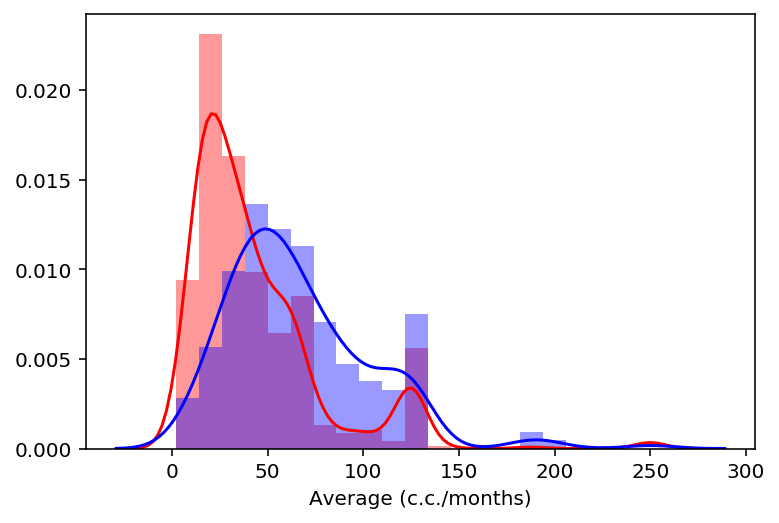

In [25]:
transfusion['Average (c.c./months)'] = transfusion['Volume'] / transfusion['Time']

plot_distribution(transfusion, 'Average (c.c./months)', 'Target')

The average occasions that have been donated per month.

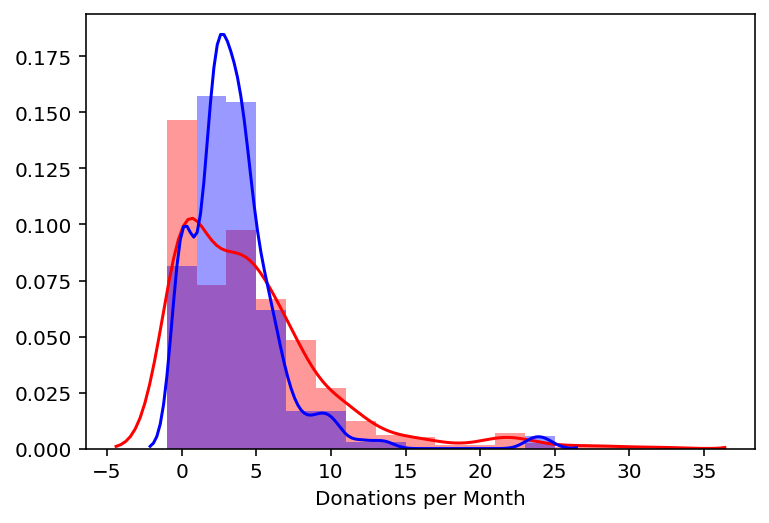

In [26]:
transfusion['Donations per Month'] = (transfusion['Time'] - transfusion['Recency']) / transfusion['Frequency']

plot_distribution(transfusion, 'Donations per Month', 'Target')

If blood donation is done frequently. This assumes that the frequent donor is the one that has a higher frequency than the median set.

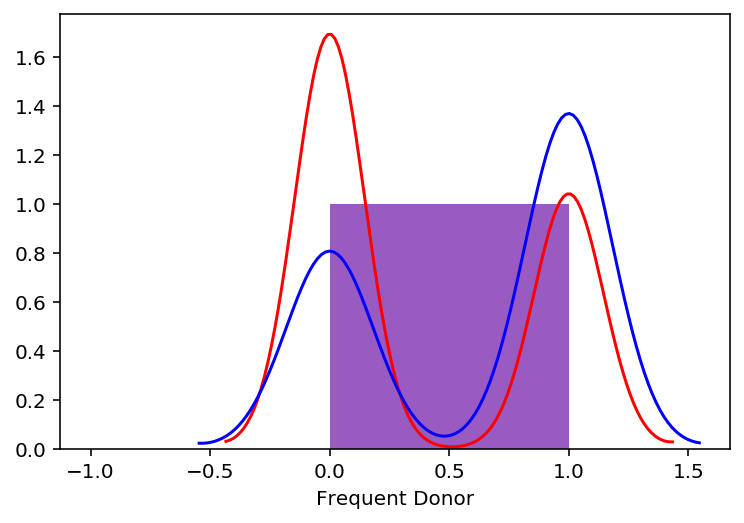

In [27]:
transfusion['Frequent Donor'] = transfusion['Frequency'] > median(transfusion['Frequency'])

plot_distribution(transfusion, 'Frequent Donor', 'Target')

## Analysis of news features
Once the new features are created, the initially performed analysis can be repeated. Correlation can be checked

In [28]:
transfusion.corr()

,Recency,Frequency,Volume,Time,Target,Average (c.c./months),Donations per Month,Frequent Donor
Recency,1.000000,-0.182745,-0.182745,0.160618,-0.279869,-0.499594,-0.051441,-0.207978
Frequency,-0.182745,1.000000,1.000000,0.634940,0.218633,0.244419,0.031779,0.655253
Volume,-0.182745,1.000000,1.000000,0.634940,0.218633,0.244419,0.031779,0.655253
Time,0.160618,0.634940,0.634940,1.000000,-0.035854,-0.331158,0.592473,0.553611
Target,-0.279869,0.218633,0.218633,-0.035854,1.000000,0.260239,-0.087510,0.213201
Average (c.c./months),-0.499594,0.244419,0.244419,-0.331158,0.260239,1.000000,-0.411783,0.128697
Donations per Month,-0.051441,0.031779,0.031779,0.592473,-0.087510,-0.411783,1.000000,0.080118
Frequent Donor,-0.207978,0.655253,0.655253,0.553611,0.213201,0.128697,0.080118,1.000000


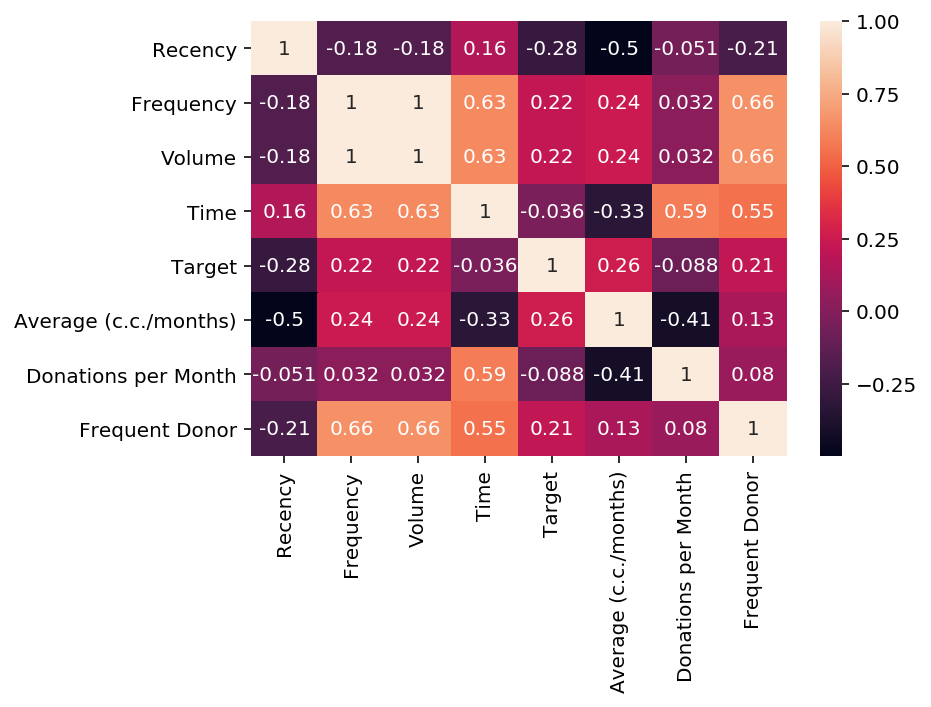

In [29]:
heatmap(transfusion.corr(), annot = True);

## Elimination of collinear features  
We can use VIF (Variance inflation factor) method.

In [30]:
from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        if model.score(data[x_features], data[y_featue]) == 1:
            result[y_featue] = Infinity
        else:
            result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

def selectDataUsingVIF(data, max_VIF = 5):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        
    return result

In [31]:
calculateVIF(transfusion)

,Recency,Frequency,Volume,Time,Target,Average (c.c./months),Donations per Month,Frequent Donor
VIF,2.031188,inf,inf,7.88041,1.171853,2.104857,3.341691,2.212202


It can be seen that there is a large multicollinearity between the different characteristics of the model. In fact, there are two features with Infinite VIF, indicating perfect multicollinearity. You can use the algorithm to select only those that have a VIF less than 5.  
We note that the Target variable will be our dependent variable so it should remain in the dataframe.

In [33]:
transf_selection = selectDataUsingVIF(transfusion, 5)
calculateVIF(transf_selection)

,Recency,Volume,Target,Average (c.c./months),Donations per Month,Frequent Donor
VIF,1.567866,1.86597,1.147909,1.909312,1.377558,1.814119


## Modeling
Before proceeding to the creation of models knows how to divide the dataset is a training set and a test set.

In [34]:
from sklearn.model_selection import train_test_split

target = 'Target'
features = list(transf_selection.columns)
features.remove(target)

x_train, x_test, y_train, y_test = train_test_split(transf_selection[features], transf_selection[target],  random_state = 0)

### Basic Model (Dummy Classifier)  
As a starting point, two simple classifiers were used to classify donors based on the raw data set. The first one we use as a reference is a dummy classifier, a simple scikit learning classifier that produces a random result, this is useful for comparing it to the other models.

In [44]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier()
dc.fit(x_train, y_train)
print(u'The performance of the model is: %0.5f' % dc.score(x_test, y_test))

The performance of the model is: 0.55080


### Logistic regression
The first model to evaluate will be logistic regression. In this model you will only use to modify the number of characteristics used. First, a `Pipeline` is created as a standard process.

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('kBest', SelectKBest(f_classif, k = 2)),
                 ('lr', LogisticRegression())])

pipe.fit(x_train, y_train)

print(u'The performance of the model is: %0.5f' % pipe.score(x_test, y_test))

The performance of the model is: 0.70053


The forecast for this model is 70%. This is a reference point for the following models. Now you can check if the model can be improved by changing the number of features used.

In [36]:
from sklearn.model_selection import GridSearchCV

parameters = dict(kBest__k = range(1,  len(features)))

grid = GridSearchCV(pipe, param_grid = parameters, cv = 5)

grid.fit(x_train, y_train)

print(u'The performance of the model is: %0.5f' % grid.score(x_test, y_test))

grid.best_params_

The performance of the model is: 0.71123


{'kBest__k': 4}

It can be seen that the model improves slightly from two characteristics to four.

### Random Forest
The next model used will be Random Forest. For this classifier you will test how it affects the number of estimators and the maximum depth of the trees used. Like the previous case, a standard `Pipeline` is initially created.

In [40]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('kBest', SelectKBest(f_classif, k = 5)),
                 ('rf', RandomForestClassifier(max_depth = 2))])

pipe.fit(x_train, y_train)

print(u'The performance of the model is: %0.5f' % pipe.score(x_test, y_test))

The performance of the model is: 0.72193


The initial performance of the model is 72%. You can now prove that it happens when you modify the settings.

In [41]:
parameters = dict(kBest__k = range(1,  len(features)),
                  rf__n_estimators = [25, 50, 75],
                  rf__max_depth = [1, 2, 3, 4, 5],
                  rf__random_state = [0])

grid = GridSearchCV(pipe, param_grid = parameters, cv = 5)

grid.fit(x_train, y_train)

print(u'The performance of the model is: %0.5f' % grid.score(x_test, y_test))

grid.best_params_

The performance of the model is: 0.78075


C:\Users\JoseLuisFernandez\Anaconda3\envs\Area_de_Trabajo\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'kBest__k': 3,
 'rf__max_depth': 4,
 'rf__n_estimators': 25,
 'rf__random_state': 0}

Cross-validation results in a configuration that allows for better models than the first one.

### Support Vector Machine (SVM)
Finally a `Pipeline` is created for the supportvector machines

In [57]:
from sklearn.svm import SVC

pipe = Pipeline([('kBest', SelectKBest(f_classif, k = 5)),
                 ('svm', SVC(kernel = 'rbf'))])

pipe.fit(x_train, y_train)

print(u'The performance of the model is: %0.5f' % pipe.score(x_test, y_test))

The performance of the model is: 0.70053


The initial yield is 70%, which is lower than the previous model.  
Let's see what you can get by modifying the settings.

In [58]:
parameters = dict(kBest__k = range(1,  len(features)),
                  svm__kernel = ['rbf', 'sigmoid'],
                  svm__C = [0.1, 1, 10, 100, 1000], 
                  svm__gamma = [0.1, 0.01, 0.001, 0.0001, 0.00001],
                  svm__random_state = [0])

grid = GridSearchCV(pipe, param_grid = parameters, cv = 5)

grid.fit(x_train, y_train)

print(u'The performance of the model is: %0.5f' % grid.score(x_test, y_test))

grid.best_params_

The performance of the model is: 0.75401


C:\Users\JoseLuisFernandez\Anaconda3\envs\Area_de_Trabajo\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'kBest__k': 2,
 'svm__C': 10,
 'svm__gamma': 0.001,
 'svm__kernel': 'rbf',
 'svm__random_state': 0}

The model improves considerably but still not better than it was previously with Random Forest.

### Model optimization  
Let's take a more spin and apply to the data a normalization and rescale of the data, generating new polynomial variables from the existing numerical ones using the preprocessing library. PolynomialFeatures by sklearn. And finally we will apply a Main Component Analysis algorithm that reduces our dimensional space without losing significant information. This whole process will be added to a new Pipeline.

In [56]:
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('norm', Normalizer()),
    ('poly', PolynomialFeatures(degree=2)),
    ('norm2',Normalizer()),
    ('pca', PCA(n_components=3)),
    ('rf', RandomForestClassifier(max_depth = 4, n_estimators=25))])

pipe.fit(x_train, y_train)

print(u'The performance of the model is: %0.5f' % pipe.score(x_test, y_test))

The performance of the model is: 0.77540


We couldn't improve the original model so we would use the first version of the configured Ramdon Forrest model.